# Image Classification with Convolutional Neural Networks
We will classify images in this assignment. Convolutional neural networks are very successful with images. A convolutional neural network contains at least one convolutional layer and commonly pooling and dense layers.

Convolutional layers perform a series of convolution operations. A convolution operation consists of elementwise multiplication of a convolutional filter and a slice of input (part of image) that has the same size as the convolutional filter. Output of the convolution operation is the sum of the elementwise products.

For a given input

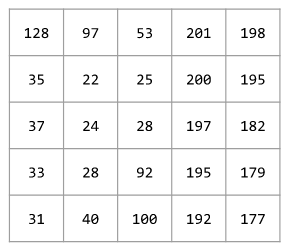

and a convolutional filter

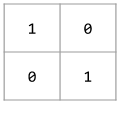

the output of one convolutional operation is calculated as

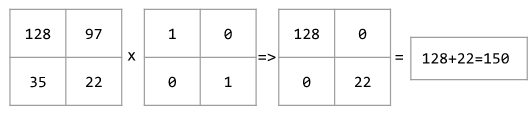

The weights in the convolutional filters are learned in convolutional neural networks in addition to the weights in the possibly existing dense layers.

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

plt.style.use("ggplot")

2022-10-03 16:48:29.310673: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) is an image recognition dataset with images from 10 classes of vehicles and animals. It is available as a dataset in Tensorflow. We load the dataset and normalize the pixel values to \[0, 1\].

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

We get the shape of the images which we will need later in the code.

In [3]:
image_shape = train_images.shape[1:]
image_shape

(32, 32, 3)

We can plot the first 10 images.

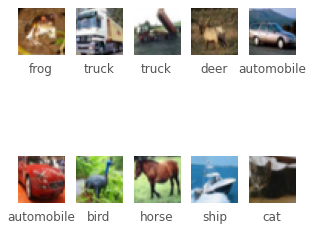

In [4]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

plt.figure(figsize=(5, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Building the Classifier

We will use the Sequential API of Keras models. Keras provides higher level layers and functions to build neural networks, it acts an interface to TensorFlow. Our model will have 3 convolutional stacks of Conv2D and MaxPooling2D layers. These stacks are very commonly used in convolutional neural networks. Conv2D layers perform convolution operations. MaxPooling2D layers downsample their input by taking the maximum value within a grid whose size is determined by the argument to the layer. In our model, all maxpooling layers downsample a 2$\times$2 grid and all convolutional layer filters are 3$\times$3. We use 32 filters in the first convolutional layer and 64 in the latter ones. We use the ReLU non-linearity in each convolutional layer.

Each image is represented as 3D arrays; one array for each of the red,  blue and green channels. This is reflected in the input_shape to the first Conv2D layer: input size is 32$\times$32$\times$3.

There are two other important parameters of the Conv2D layer. Stride determines how much the filter is shifted in each dimension. A stride > 1 results in smaller outputs of the convolutional layer. The second parameter is padding. Padding='valid' keeps outputs of filters that are fully in the image (no padding is applied), padding='same' keeps the image size by zero-padding the image.

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=image_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))

2022-10-03 16:48:32.767736: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-03 16:48:32.788547: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-03 16:48:34.735232: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-03 16:48:34.735397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3050 Laptop GPU computeCapability: 8.6
coreClock: 1.057GHz coreCount: 16 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 163.94GiB/s
2022-10-03 16:48:34.735478: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-10-03 16:48:34.786657: I tensorflow/stream_exec

The last layer will have 10 nodes: one for each of the classes in the dataset. Adding one or more dense layer(s) before the last layer allows the model to learn complex representations of the images. Between the convolutional stacks and the dense layers, there needs to be a layer for flattening since the output of the last convolutional layer is 4$\times$4$\times$64.

In [8]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10))

Summary of the model gives useful information: shapes of output layers and number of parameters in each layer. "None" values in the first dimension of layer output shapes are placeholders for the batch size.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

Finally, we need to compile and fit our model. There are a number of optimizers available in Keras we will use Adam optimizer. We choose loss as SparseCategoricalCrossentropy which should be selected when the task is classification and the labels are not in one-hot-vector form. For one-hot labels, use CategoricalCrossentropy loss instead. There are two ways to use (Sparse)CategoricalCrossentropy: from_logits=True works with pre-softmax values in which case the output of the last layer in the network is linear, from_logits=False works with softmax outputs directly. Note that using logits is reported to be more numerically stable.

In [10]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_images, train_labels, epochs=10, batch_size=5, validation_data=(test_images, test_labels)
)

2022-10-03 16:55:54.573194: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.
2022-10-03 16:56:00.813815: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-03 16:56:00.821342: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2687995000 Hz


Epoch 1/10


2022-10-03 16:56:01.722449: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-03 16:56:02.852876: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


History object returned by fit contains the training and validation accuracies. From the plot, we can see that our model overfit to the training data. This is also evident from the test accuracy.

We can evaluate the model on the test set with `model.evaluate` to understand the generalization performance of our model.

In [ ]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

## Confusion Matrix
Confusion matrices visualize performance of classification algorithms in a table layout. Scikit-learn has an implementation of confusion matrix for multiclass data. Each class prediction is treated as one-vs-rest.

Our CNN model is set up to output logits, hence the `predict` method also returns logits. We will use the `softmax` function to get class probabilities for each test image, then use the class for which the probability was highest.

In [ ]:
logits = model.predict(test_images)
preds = tf.math.argmax(tf.nn.softmax(logits), axis=1)

For a two class classification problem would look like 

|Predicted/True| 0 | 1   |
|-------------|------|------|
|0             |True negative|False positive|
|1        |False negative|True positive|

For the ten classes in CIFAR10 dataset, the main diagonal of the confusion matrix shows the number of correctly predicted examples in each class. In general, for row $i$ and column $j$, entry $c_{ij}$ in the confusion matrix shows the number of class $i$ examples that are predicted as class $j$.


In [ ]:
conf_mat = confusion_matrix(test_labels, preds)

To get information about the predictions for images in, for example, the "deer" class, we can extract the fourth row ("deer" is the fourth class") in the confusion matrix.

In [ ]:
conf_mat[4]
conf_mat = conf_mat.astype("float") / conf_mat.sum(axis=1)[:, np.newaxis]

In [ ]:
def plot_confusion_matrix(cm, classes, title="Confusion matrix", cmap=plt.cm.Blues):
    """
    Plots the confusion matrix.
    """
    import itertools

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = "2.2f"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

In [ ]:
plt.figure(figsize=(20, 7))
plot_confusion_matrix(conf_mat, classes=class_names)

## K-fold cross-validation

Scikit provides implementations of many useful techniques and tools commonly used in machine learning. One such technique is k-fold cross-validation which works with scikit classifiers. We can wrap our tensorflow model to act like a Scikit classifier. tf.keras provides a wrapper "KerasClassifier" to turn a tf.Keras model into a Scikit classifier.

"KerasClassifier" expects a function that builds a Keras model, so we will gather model building code into a function.

In [ ]:
def create_model(
    filter_nos=[32, 32, 32],
    filter_size=(3, 3),
    dense_layers=[64],
    input_shape=image_shape,
):
    """
    Args:
        filter_nos (tuple): number of filters in each Conv2D layer
        filter_size (tuple): size of Conv2D filters. Filters are assumed to have uniform sizes across layers.
        input_shape (tuple): shape of the input of the first layer
        dense_layer (tuple): number of hidden units in each Dense layer except the output layer. Output layer is hardcoded to the number of classes.
    """

    model = models.Sequential()

    for i, filter_no in enumerate(filter_nos):
        if i == 0:
            # first Conv2D requires input_shape
            model.add(
                layers.Conv2D(
                    filter_no, filter_size, activation="relu", input_shape=input_shape
                )
            )
        else:
            model.add(layers.Conv2D(filter_no, filter_size, activation="relu"))

        if i + 1 < len(filter_nos):
            model.add(
                layers.MaxPooling2D((2, 2))
            )  # add MaxPooling layer to all but the last convolutional stack

    model.add(layers.Flatten())

    for dense_layer in dense_layers:
        model.add(layers.Dense(dense_layer, activation="relu"))

    model.add(layers.Dense(10))  # output layer

    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

For instance, using the create model function, we could reproduce the model we had built before as before.

In [ ]:
model = create_model(filter_nos=(32, 64, 64), filter_size=(3, 3), dense_layers=(64,))
model.summary()

We will use the KerasClassifier as the estimator in `cross_val_score`. It accepts the function that builds our Keras model, arguments to that function as well as training parameters `epochs` and `batch_size`.

In [ ]:
model = KerasClassifier(
    create_model,
    filter_nos=(32, 64, 64),
    filter_size=(3, 3),
    dense_layers=(64,),
    epochs=10,
    batch_size=32,
)

We also need to create an object that handles data splitting for k-fold cross-validation. `StratifiedKFold` does this.

In [ ]:
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds)
fold_accuracies = cross_val_score(
    estimator=model, X=train_images, y=train_labels, cv=kfold
)

Finally, we can print the mean accuracy and the 95\% confidence interval.

In [ ]:
print(
    "Accuracy: {:.3f} (+/- {:.3f})".format(
        fold_accuracies.mean(), fold_accuracies.std() * 2
    )
)

## Exercise

We had observed that the CNN model had overfit the training data. Implement `EarlyStopping`, `Dropout` and $l_2$  regularization techniques to reduce overfitting. You can use all three together or separately to compare performance. Plot training and validation accuracies with the regularized model(s).


*Hint:* This can be done by adding layers to the model and/or adding Keras callbacks. To add layers to the model, you'll need to redefine the architecture of the model. 

Here are relevant documentation: [$l_2$](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2), [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout), [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

Content in this notebook is borrowed and adapted from [Convolutional Neural Network (CNN)](https://www.tensorflow.org/tutorials/images/cnn) which is licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

Please contact Zeynep Hakguder (<a href="mailto:zphakguder@gmail.com">zphakguder@gmail.com</a>) for further questions or inquries.